In [1]:
#we are going to import the geracao dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error
import os

In [2]:
dataset = pd.read_csv('data.csv')
#del dataset["Unnamed: 0"]
#print(dataset.head)

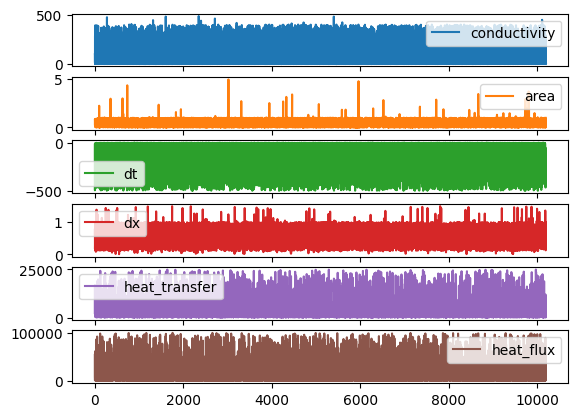

In [3]:
#we are going to plot every single data in the dataset to see how it looks like
dataset.plot(subplots=True)
plt.show()
#saving the plot as a image

In [4]:
#our y or target will be the heat_flx
target = dataset["heat_flux"]
#our x or features will be the rest of the dataset
dados = dataset[["conductivity","area","dt","dx","heat_transfer"]]

In [5]:
print(dados)

       conductivity      area          dt        dx  heat_transfer
0         98.503149  0.762216  -19.126301  0.598072    2401.074736
1         89.217217  0.301265 -494.500769  0.787721   16872.993277
2         14.390840  0.228176  -93.148826  0.168285    1817.554411
3        285.519050  0.477720  -10.095621  0.781940    1761.036075
4          1.755435  0.865920 -483.354270  0.321373    2286.227895
...             ...       ...         ...       ...            ...
10193    140.169446  0.003498 -273.821645  0.689999     194.598914
10194      3.269767  0.347675 -127.292609  0.120622    1199.686142
10195     10.997496  0.481342 -295.482234  0.997222    1568.508923
10196      3.082087  0.342696 -354.333312  0.994156     376.453706
10197      2.820006  0.976770 -388.848591  0.739910    1447.583461

[10198 rows x 5 columns]


In [6]:
print(target)

0         3150.122132
1        56007.082150
2         7965.591306
3         3686.335925
4         2640.228677
             ...     
10193    55625.321431
10194     3450.594922
10195     3258.618400
10196     1098.505368
10197     1482.011166
Name: heat_flux, Length: 10198, dtype: float64


In [7]:
target = np.array(target)
dados = np.array(dados)

In [8]:
print(dados)

[[ 9.85031491e+01  7.62216395e-01 -1.91263014e+01  5.98072343e-01
   2.40107474e+03]
 [ 8.92172175e+01  3.01265351e-01 -4.94500769e+02  7.87721497e-01
   1.68729933e+04]
 [ 1.43908399e+01  2.28175705e-01 -9.31488259e+01  1.68285039e-01
   1.81755441e+03]
 ...
 [ 1.09974957e+01  4.81341701e-01 -2.95482234e+02  9.97221581e-01
   1.56850892e+03]
 [ 3.08208682e+00  3.42696282e-01 -3.54333312e+02  9.94156297e-01
   3.76453706e+02]
 [ 2.82000630e+00  9.76769605e-01 -3.88848591e+02  7.39910401e-01
   1.44758346e+03]]


In [9]:
#scaling both the target and the features, keep in mind that we can reverse the scaling later
scaler = StandardScaler()
dados = scaler.fit_transform(dados)
target = scaler.fit_transform(target.reshape(-1,1))

In [10]:
X_train_full, x_test, y_train_full, y_test = train_test_split(dados, target, test_size=0.25, random_state=42)


In [11]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, test_size=0.25, random_state=42)

In [12]:
def build_model(n_hidden=1, n_neurons=30, learning_rate=3e-3,activation="tanh", input_shape=[5]):
    model = keras.models.Sequential()
    options = {"input_shape": input_shape}
    for layer in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons, activation=activation, **options))
        options = {}
    model.add(keras.layers.Dense(1))
    optimizer = keras.optimizers.SGD(lr=learning_rate)
    model.compile(loss="mse", optimizer=optimizer)
    return model

In [13]:
keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model)

C:\Users\lucca\AppData\Local\Temp\ipykernel_16868\1709004121.py:1: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model)


In [14]:
param_distribs = {
    "n_hidden": [0, 1, 2, 3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20],
    "n_neurons": np.arange(10, 256),
    "learning_rate": reciprocal(3e-5, 3e-2),
    "activation": ["tanh"],
}

In [15]:
rnd_search_cv = RandomizedSearchCV(keras_reg, param_distribs, n_iter=5,n_jobs=1,cv=3)
rnd_search_cv.fit(X_train, y_train, epochs=75,
                    validation_data=(X_valid, y_valid),
                    callbacks=[keras.callbacks.EarlyStopping(patience=5,monitor="val_loss")],verbose=2)

Epoch 1/75


c:\Users\lucca\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


120/120 - 1s - loss: 0.4830 - val_loss: 0.4490 - 974ms/epoch - 8ms/step
Epoch 2/75
120/120 - 0s - loss: 0.4164 - val_loss: 0.4031 - 195ms/epoch - 2ms/step
Epoch 3/75
120/120 - 0s - loss: 0.3683 - val_loss: 0.3439 - 183ms/epoch - 2ms/step
Epoch 4/75
120/120 - 0s - loss: 0.3027 - val_loss: 0.2790 - 167ms/epoch - 1ms/step
Epoch 5/75
120/120 - 0s - loss: 0.2303 - val_loss: 0.1991 - 212ms/epoch - 2ms/step
Epoch 6/75
120/120 - 0s - loss: 0.1651 - val_loss: 0.1479 - 176ms/epoch - 1ms/step
Epoch 7/75
120/120 - 0s - loss: 0.1169 - val_loss: 0.1020 - 176ms/epoch - 1ms/step
Epoch 8/75
120/120 - 0s - loss: 0.0848 - val_loss: 0.0765 - 181ms/epoch - 2ms/step
Epoch 9/75
120/120 - 0s - loss: 0.0650 - val_loss: 0.0631 - 185ms/epoch - 2ms/step
Epoch 10/75
120/120 - 0s - loss: 0.0533 - val_loss: 0.0513 - 197ms/epoch - 2ms/step
Epoch 11/75
120/120 - 0s - loss: 0.0453 - val_loss: 0.0490 - 186ms/epoch - 2ms/step
Epoch 12/75
120/120 - 0s - loss: 0.0396 - val_loss: 0.0409 - 180ms/epoch - 2ms/step
Epoch 13/75


RandomizedSearchCV(cv=3,
                   estimator=<keras.wrappers.scikit_learn.KerasRegressor object at 0x0000020363E3BA60>,
                   n_iter=5, n_jobs=1,
                   param_distributions={'activation': ['tanh'],
                                        'learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x0000020363E3B820>,
                                        'n_hidden': [0, 1, 2, 3, 4, 5, 6, 7, 8,
                                                     9, 10, 11, 12, 13, 14, 15,
                                                     16, 17, 18, 19, 20],
                                        'n_neurons': array([...
       166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178,
       179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191,
       192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204,
       205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217,
       218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230,
       231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243,
       244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255])})

In [16]:
model = rnd_search_cv.best_estimator_.model

In [17]:
hist = model.history.history

In [18]:
rnd_search_cv.best_params_

{'activation': 'tanh',
 'learning_rate': 0.0027810026241591465,
 'n_hidden': 8,
 'n_neurons': 59}

In [19]:
model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_144 (Dense)           (None, 59)                354       
                                                                 
 dense_145 (Dense)           (None, 59)                3540      
                                                                 
 dense_146 (Dense)           (None, 59)                3540      
                                                                 
 dense_147 (Dense)           (None, 59)                3540      
                                                                 
 dense_148 (Dense)           (None, 59)                3540      
                                                                 
 dense_149 (Dense)           (None, 59)                3540      
                                                                 
 dense_150 (Dense)           (None, 59)              

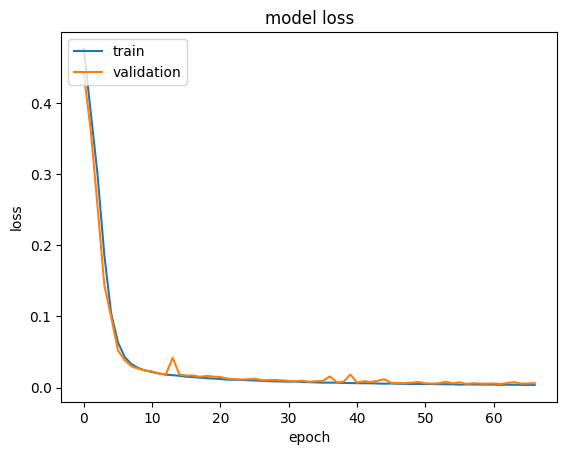

In [20]:
#ploting the loss and the validation loss
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "validation"], loc="upper left")
plt.show()


In [21]:
mse_test = model.evaluate(x_test, y_test) #mse

80/80 [==============================] - 0s 911us/step - loss: 0.0043


In [22]:
y_pred = model.predict(x_test)
y_pred = y_pred.flatten()

80/80 [==============================] - 0s 821us/step


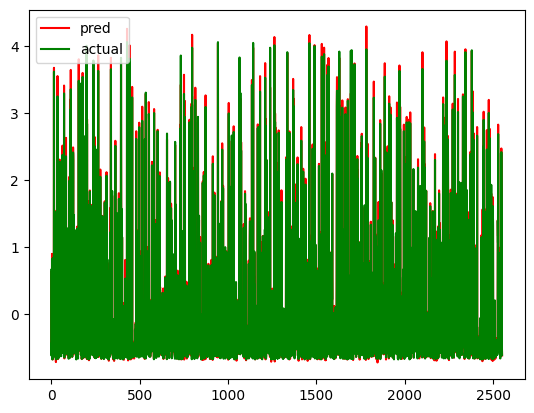

In [23]:
#we have to convert the y_test back to its original shape
#we are going to inverse the scaling of the y_pred, since we scaled it before
#inverse scaling both the y_pred and the y_test
#y_pred = scaler.inverse_transform(y_pred.reshape(-1,1))
#y_test = scaler.inverse_transform(y_test.reshape(-1,1))

plt.plot(y_pred, color="red", label="pred")
plt.plot(y_test, color="green", label="actual")
plt.legend(loc="upper left")
plt.show()

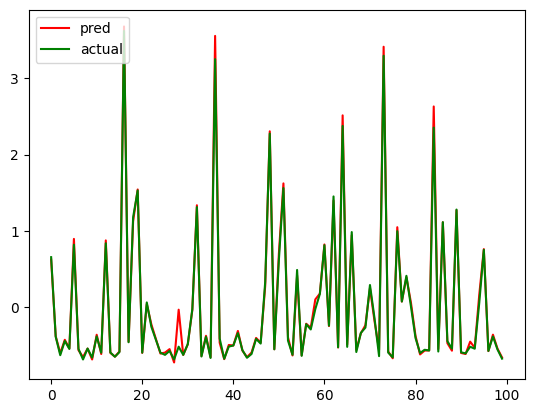

In [24]:
#plotting just the first 100 predictions and values
plt.plot(y_pred[:100], color="red", label="pred")
plt.plot(y_test[:100], color="green", label="actual")
plt.legend(loc="upper left")
plt.show()


In [25]:
mean_squared_error(y_test, y_pred)

0.004276536049085694

In [26]:
#showing the predictions of the first 10 values 
y_pred_inversed = scaler.inverse_transform(y_pred.reshape(-1,1))
y_test_inversed = scaler.inverse_transform(y_test.reshape(-1,1))
for i in range(10):
    print("pred: ", y_pred_inversed[i], "actual: ", y_test_inversed[i])


pred:  [27505.379] actual:  [28151.32856363]
pred:  [6420.222] actual:  [6268.34801093]
pred:  [1711.4321] actual:  [1190.49717027]
pred:  [5422.5103] actual:  [5102.0064358]
pred:  [3033.1392] actual:  [2910.20508067]
pred:  [33174.895] actual:  [31581.20540635]
pred:  [2572.522] actual:  [2934.86491735]
pred:  [685.1548] actual:  [9.63914399]
pred:  [3004.5083] actual:  [3021.84422778]
pred:  [12.153779] actual:  [535.75892636]


In [27]:
dataset_test = pd.read_csv('teste.csv')

In [28]:
#setting up the target and the data
target = dataset_test["heat_flux"]
dados = dataset_test[['conductivity','area','dt','dx','heat_transfer']]
#scaling the data
scaler = StandardScaler()
dados = scaler.fit_transform(dados)
target = target.values.reshape(-1,1)
target = scaler.fit_transform(target)


In [29]:
new_mse_test = model.evaluate(dados, target)

182/182 [==============================] - 0s 863us/step - loss: 0.0047


In [32]:
print("mse test: ", mse_test)
print("mse new test: ", new_mse_test)

mse test:  0.004276536405086517
mse new test:  0.004700473044067621


In [33]:
#the name of the model will include its amount of hidden layers, its amount of neurons and the amount of indexes in the dataset
#that were used to train it
amount = len(dataset)

name = "model_" + str(rnd_search_cv.best_params_["n_hidden"]) + "_" + str(rnd_search_cv.best_params_["n_neurons"]) +  "_"+ str(amount) + ".h5"
model.save(name)
print("model saved")

model saved


In [34]:
#showing the first 10 predctions and the real values
y_pred = model.predict(dados)
y_pred = y_pred.flatten()

for i in range(10):
    print("pred: ", y_pred[i], "actual: ", target[i])

182/182 [==============================] - 0s 865us/step
pred:  0.65834117 actual:  [0.77344097]
pred:  -0.49404538 actual:  [-0.48591186]
pred:  0.2215168 actual:  [0.17190064]
pred:  -0.49850434 actual:  [-0.51384273]
pred:  -0.644606 actual:  [-0.63844969]
pred:  -0.5425838 actual:  [-0.54846112]
pred:  1.9223872 actual:  [1.94576094]
pred:  -0.5784106 actual:  [-0.5854446]
pred:  -0.35635084 actual:  [-0.35426049]
pred:  -0.52567685 actual:  [-0.52717698]


In [35]:
#Plotting the predictions and the real values
y_pred_inversed = scaler.inverse_transform(y_pred.reshape(-1,1))
target_inversed = scaler.inverse_transform(target.reshape(-1,1))

for i in range(10):
    print("pred: ", y_pred_inversed[i], "actual: ", target_inversed[i])

pred:  [28974.178] actual:  [31443.25861936]
pred:  [4253.5864] actual:  [4428.0633002]
pred:  [19603.574] actual:  [18539.22623749]
pred:  [4157.934] actual:  [3828.89992583]
pred:  [1023.81274] actual:  [1155.8751374]
pred:  [3212.3557] actual:  [3086.27844545]
pred:  [56090.055] actual:  [56591.45562271]
pred:  [2443.8118] actual:  [2292.92169363]
pred:  [7207.361] actual:  [7252.20220015]
pred:  [3575.0383] actual:  [3542.85834261]


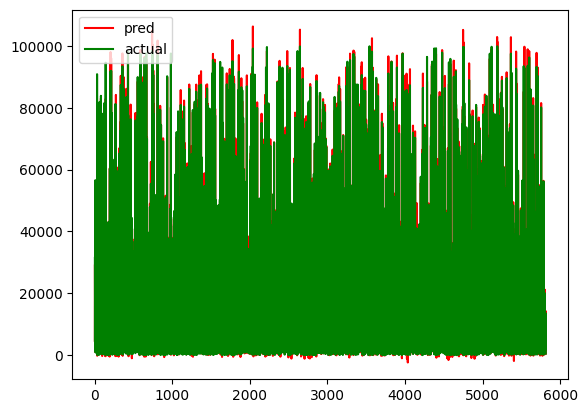

In [36]:
plt.plot(y_pred_inversed, color="red", label="pred")
plt.plot(target_inversed, color="green", label="actual")
plt.legend(loc="upper left")
plt.show()